# Controlling Eigenfluids
## Optimizing for Initial Velocity Field (i.e. basis coefficients) given start and target positions

Given starting positions $P_{0} = [p_{0,0}\dots p_{0,i}]$, and target positions $P_{t} = [p_{t,0}\dots p_{t,i}]$ ($i = [1, \text{number of sample points}]$), we optimize for an initial basis coefficient vector $\omega_{optim}$, such that each starting point $p_{0,i}$ will end up at the corresponding target positions $p_{target, i}$ when simulated for $t$ time steps in a fluid flow with initial velocity $v_{optim}$, initial velocity field reconstructed from $\omega_{optim}$.

TLDR:
$$
\arg\min_{\omega} \Big|\mathcal{P}^{t}(P_0, \omega) - P_t\Big|_2^2 =
\arg\min_{\omega} \sum_{i}\Big|\mathcal{P}^{t}(p_{0,i}, \omega) - p_{t,i}\Big|_2^2
$$
where $\mathcal{P}^t$ is the physical simulation of the fluid and the points over $t$ timesteps.

In [1]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid
from src.shapes import *

# Helper functions for visualization
from src.visu import *

import time

In [2]:
# Number of basis fields
N = 4**2
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 32

In [3]:
start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 5.908816814422607 seconds


# Initialize Start and Target Setup

<Figure size 216x216 with 1 Axes>

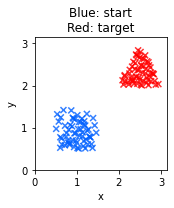

In [4]:
#c = Circle(pos=(1.5, 1.5), radius=1)
#s = Square(pos=(1.5, 1.5))
#t = Triangle(pos=(0.5, 0.5))

shape_0 = Square(pos=(0.5, 0.5))
shape_target = Triangle(pos=(2, 2))

# Get O overlapping, and U non-necessarily overlapping ('unique') sample points
O = 30
U = 30
sampler_union = ShapeSampler(shape_0, shape_target, N=O, h1=2, h2=7)
sampler_0 = ShapeSampler(shape_0, N=U, h1=3, h2=11)
sampler_target = ShapeSampler(shape_target, N=U, h1=3, h2=11)

# Concatenate both the union and non-union points
p_0 = math.concat((sampler_union.p, sampler_0.p), instance('i'))
p_0 = shape_0.create_points(p_0)
p_target = math.concat((sampler_union.p, sampler_target.p), instance('i'))
p_target = shape_target.create_points(p_target)

plot({"Blue: start\nRed: target": 
     vis.overlay(
        PointCloud(p_0, bounds=DOMAIN),
        PointCloud(p_target, bounds=DOMAIN, color="red")
     )}, 
     size=(3,3))

# Optimize Initial Velocity Field for Target Positions

In [5]:
STEPS = 32
DT    = 0.2
VISCOSITY = 0.0

def loss_function(w, p, p_target):
    eigenfluid.w = w
    trajectory_p = [p]
    for i in range(STEPS-1):
        # Step velocity
        eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT, viscosity=VISCOSITY)
        # Get velocities at new positions
        p_velocities = eigenfluid.get_phi_at(p)
        # Midpoint
        p_velocities = eigenfluid.get_phi_at(p + p_velocities*DT/2)
        # Euler step for points
        p += p_velocities * DT
        trajectory_p.append(p)
    # Normalizing by the number of sample points
    loss = field.l2_loss(p - p_target) / p.i.size
    return (loss, trajectory_p)

gradient_function = math.gradient(loss_function)

In [6]:
# Initialize w to some value for optimization (~0 or random)
w_init = math.zeros_like(eigenfluid.w) + 0.001
#w_init = math.random_normal(eigenfluid.w.shape)

# first gradient
(loss, trajectory_p), grad = gradient_function(w_init, p_0, p_target)
print("Initial Loss: {}".format(loss))

Initial Loss: 2.20314


In [7]:
LR = 10**-2

w_optim = w_init
grads = [0] #initialize to 0 for momentum
momentum = 0
for optim_step in range(52):
    (loss, trajectory_p), grad = gradient_function(w_optim, p_0, p_target)
    if optim_step%3 == 0 or optim_step < 5:
        print("Optimization step %d, loss: %f" % (optim_step, loss))
    if optim_step == 21: 
        LR /= 2
        print("LR = {}".format(LR))
        
    grads.append( grad[0] )

    # optionally with momentum
    w_optim = w_optim - LR * (grads[-1] + 0.85*grads[-2]) 

Optimization step 0, loss: 2.203140
Optimization step 1, loss: 1.647497
Optimization step 2, loss: 1.128018
Optimization step 3, loss: 0.815472
Optimization step 4, loss: 0.584571
Optimization step 6, loss: 0.369269
Optimization step 9, loss: 0.248836
Optimization step 12, loss: 0.189599
Optimization step 15, loss: 0.152994
Optimization step 18, loss: 0.128659
Optimization step 21, loss: 0.111995
LR = 0.005
Optimization step 24, loss: 0.105831
Optimization step 27, loss: 0.100674
Optimization step 30, loss: 0.096324
Optimization step 33, loss: 0.092640
Optimization step 36, loss: 0.089508
Optimization step 39, loss: 0.086833
Optimization step 42, loss: 0.084538
Optimization step 45, loss: 0.082559
Optimization step 48, loss: 0.080846
Optimization step 51, loss: 0.079356


### Plot Results of Optimization

In [13]:
#trajectory_p = math.stack(trajectory_p, batch('time'))
#target_time = math.stack([p_target]*STEPS, batch('time'))

#trajectory_v = math.stack(trajectory_v, batch('time'))
#trajectory_curl_ref = math.stack(trajectory_curl, batch('time'))

#velocity_field = math.stack([eigenfluid.reconstruct_velocity()]*STEPS, batch('time'))

vis.plot(vis.overlay(PointCloud(trajectory_p, bounds=DOMAIN),
                     PointCloud(target_time, bounds=DOMAIN, color="red")
                    ),
        animate='time',
        same_scale=False,
        size=(4,4)
)

<Figure size 432x288 with 0 Axes>

# Compare Results with Advection of Smoke Marker

In [14]:
def init_smoke():
    smoke = CenteredGrid(
        Box['x,y', 0.5:1.5, 0.5:1.5], 
        extrapolation.BOUNDARY, 
        x=100, y=100, 
        bounds=DOMAIN
    )
    return smoke

In [15]:
eigenfluid.w = w_optim

velocity = eigenfluid.reconstruct_velocity()
smoke = init_smoke()

vel_traj = [velocity]
w_traj = [eigenfluid.w]
smoke_traj = [smoke]

start_time = time.time()
for i in range(STEPS-1):
    # Simulate
    eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT, viscosity=VISCOSITY)
    velocity = eigenfluid.reconstruct_velocity()
    smoke = advect.mac_cormack(smoke, velocity, dt=DT)
    # Save trajectory
    vel_traj.append(velocity)
    w_traj.append(eigenfluid.w)
    smoke_traj.append(smoke)
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

Simulation finished in 3.245364189147949 seconds


In [16]:
trajectory_v = math.stack(vel_traj, batch('time'))
#trajectory_curl = math.stack(trajectory_curl, batch('time'))
trajectory_smoke = math.stack(smoke_traj, batch('time'))
trajectory_w = math.stack(list(map(get_w_point_cloud, [w*10 for w in w_traj])), batch('time'))

vis.plot({
    "Blue points: simulated points\nRed points: target points\nOverlayed with independent\nhigh-res smoke sim.": 
    vis.overlay(
        trajectory_smoke,
        PointCloud(trajectory_p, bounds=DOMAIN),
        PointCloud(target_time, bounds=DOMAIN, color="red"),        
    ), 
    "Velocity Field": trajectory_v,
    "w basis coefficients \n(*10 for visualization)": trajectory_w
}, animate='time', same_scale=False)

<Figure size 432x288 with 0 Axes>